In [ ]:
# from reactor_ode_test import states
import matplotlib.pyplot as plt


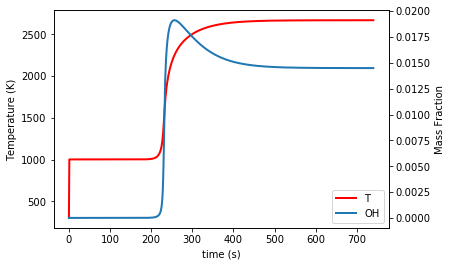

In [2]:
L1 = plt.plot(states.T, color='r', label='T', lw=2)
plt.xlabel('time (s)')
plt.ylabel('Temperature (K)')
plt.twinx()
# L2 = plt.plot(states.t, states('OH').Y, label='OH', lw=2)
L2 = plt.plot(states('OH').Y, label='OH', lw=2)
plt.ylabel('Mass Fraction')
plt.legend(L1 + L2, [line.get_label() for line in L1 + L2], loc='lower right')


plt.show()

In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

import os

os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras import backend as K

K.set_floatx('float32')
print("precision: " + K.floatx())

from keras.models import Model
from keras.layers import Dense, Input, BatchNormalization, Activation, Dropout
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from res_block import res_block

import cntk

from sklearn.utils import shuffle
from reactor_ode_p import data_gen

Using TensorFlow backend.


precision: float32
Running Cantera version: 2.4.0a1


# generate data

In [4]:
ini_T = np.linspace(1001, 2001, 10)
ini = []
for i in np.linspace(2, 0., 10):
    ini = ini + [(temp, i) for temp in ini_T]
train_org, train_new = data_gen(ini)

multiprocessing:    3.014 seconds


## Data preprocessing

In [5]:
train_org, train_new = shuffle(train_org, train_new)
train_new = train_new.drop('temperature', axis=1)

## input
in_item = train_org.columns
label_values = []
input_norm_scalers = {}
input_std_scalers = {}
for itm in in_item:
    print(itm)
    norm_scaler = MinMaxScaler()
    std_scaler = StandardScaler()
    # same input_label scaler
    # std_scaler.fit(np.concatenate([train_org[itm], train_new[itm]], axis=0).reshape(-1, 1))
    # out = std_scaler.transform(train_org[itm].values.reshape(-1, 1))
    # input scaler
    out = std_scaler.fit_transform(train_org[itm].values.reshape(-1, 1))
    # out = out/out.max()
    out = 2 * norm_scaler.fit_transform(out) - 1

    label_values.append(out)
    input_norm_scalers[itm] = norm_scaler
    input_std_scalers[itm] = std_scaler

x_train = np.concatenate(
    label_values,
    axis=1)


## output
out_item = train_new.columns
# out_item = out_item.delete(9)
# output = ['H2']
label_values = []
label_norm_scalers = {}
label_std_scalers = {}
for itm in out_item:
    print(itm)
    # same input_label scaler
    # out = input_std_scalers[itm].transform(train_new[itm].values.reshape(-1, 1))
    # input scaler
    norm_scaler = MinMaxScaler()
    std_scaler = StandardScaler()
    # out = train_new[itm].values.reshape(-1, 1)
    out = std_scaler.fit_transform(train_new[itm].values.reshape(-1, 1))
    # out = out-out.min()
    out = 2 * norm_scaler.fit_transform(out) - 1

    label_values.append(out)
    label_norm_scalers[itm] = norm_scaler
    label_std_scalers[itm] = std_scaler

y_train = np.concatenate(
    label_values,
    axis=1
)

H2
H
O2
OH
O
H2O
HO2
H2O2
N2
temperature
H2
H
O2
OH
O
H2O
HO2
H2O2
N2


# setup neural network

In [7]:
print('set up ANN')
# ANN parameters
dim_input = x_train.shape[1]
dim_label = y_train.shape[1]
n_neuron = 150
batch_size = 1024
epochs = 1000
vsplit = 0.05
batch_norm = True

# This returns a tensor
inputs = Input(shape=(dim_input,), dtype='float32')
print(inputs.dtype)
# a layer instance is callable on a tensor, and returns a tensor
x = Dense(n_neuron, name='1_base')(inputs)
# x = BatchNormalization(axis=-1, name='1_base_bn')(x)
x = Activation('relu')(x)

# less then 2 res_block, there will be variance
x = res_block(x, n_neuron, stage=1, block='a', bn=batch_norm)
x = res_block(x, n_neuron, stage=1, block='b', bn=batch_norm)

# x = res_block(x, n_neuron, stage=1, block='c', bn=batch_norm)
# x = res_block(x, n_neuron, stage=1, block='d', bn=batch_norm)

predictions = Dense(dim_label, activation='linear')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# checkpoint (save the best model based validate loss)
filepath = "./tmp/weights.best.cntk.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=10)
callbacks_list = [checkpoint]

# fit the model
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=vsplit,
    verbose=2,
    callbacks=callbacks_list,
    shuffle=True)

set up ANN
<dtype: 'float32'>
Train on 54881 samples, validate on 2889 samples
Epoch 1/1000
1s - loss: 0.5069 - acc: 0.5186 - val_loss: 0.1981 - val_acc: 0.6601
Epoch 2/1000
0s - loss: 0.1025 - acc: 0.6893 - val_loss: 0.1056 - val_acc: 0.8013
Epoch 3/1000
0s - loss: 0.0547 - acc: 0.7470 - val_loss: 0.0718 - val_acc: 0.8456
Epoch 4/1000
0s - loss: 0.0351 - acc: 0.7801 - val_loss: 0.0514 - val_acc: 0.8667
Epoch 5/1000
0s - loss: 0.0251 - acc: 0.8118 - val_loss: 0.0362 - val_acc: 0.8795
Epoch 6/1000
0s - loss: 0.0191 - acc: 0.8307 - val_loss: 0.0240 - val_acc: 0.9055
Epoch 7/1000
0s - loss: 0.0157 - acc: 0.8510 - val_loss: 0.0191 - val_acc: 0.9280
Epoch 8/1000
0s - loss: 0.0133 - acc: 0.8600 - val_loss: 0.0120 - val_acc: 0.9370
Epoch 9/1000
0s - loss: 0.0116 - acc: 0.8723 - val_loss: 0.0088 - val_acc: 0.9571
Epoch 10/1000
Epoch 00009: val_loss improved from inf to 0.00544, saving model to ./tmp/weights.best.cntk.hdf5
0s - loss: 0.0100 - acc: 0.8770 - val_loss: 0.0054 - val_acc: 0.9803
Epo

0s - loss: 5.5884e-04 - acc: 0.9855 - val_loss: 3.6756e-04 - val_acc: 0.9841
Epoch 89/1000
0s - loss: 5.1607e-04 - acc: 0.9864 - val_loss: 2.7354e-04 - val_acc: 0.9837
Epoch 90/1000
Epoch 00089: val_loss did not improve
0s - loss: 5.5306e-04 - acc: 0.9853 - val_loss: 3.7712e-04 - val_acc: 0.9920
Epoch 91/1000
0s - loss: 5.5185e-04 - acc: 0.9850 - val_loss: 2.5037e-04 - val_acc: 0.9810
Epoch 92/1000
0s - loss: 5.4531e-04 - acc: 0.9858 - val_loss: 2.2127e-04 - val_acc: 0.9927
Epoch 93/1000
0s - loss: 5.0170e-04 - acc: 0.9851 - val_loss: 2.7477e-04 - val_acc: 0.9799
Epoch 94/1000
0s - loss: 4.7954e-04 - acc: 0.9872 - val_loss: 2.4002e-04 - val_acc: 0.9834
Epoch 95/1000
0s - loss: 5.2709e-04 - acc: 0.9858 - val_loss: 4.4675e-04 - val_acc: 0.9924
Epoch 96/1000
0s - loss: 4.5738e-04 - acc: 0.9870 - val_loss: 2.4638e-04 - val_acc: 0.9913
Epoch 97/1000
0s - loss: 4.1981e-04 - acc: 0.9883 - val_loss: 2.5106e-04 - val_acc: 0.9924
Epoch 98/1000
0s - loss: 4.3290e-04 - acc: 0.9861 - val_loss: 3.20

0s - loss: 1.4097e-04 - acc: 0.9945 - val_loss: 1.5932e-04 - val_acc: 0.9862
Epoch 174/1000
0s - loss: 1.2693e-04 - acc: 0.9944 - val_loss: 1.5470e-04 - val_acc: 0.9875
Epoch 175/1000
0s - loss: 1.2752e-04 - acc: 0.9940 - val_loss: 1.8262e-04 - val_acc: 0.9886
Epoch 176/1000
0s - loss: 1.2651e-04 - acc: 0.9943 - val_loss: 1.1933e-04 - val_acc: 0.9872
Epoch 177/1000
0s - loss: 1.2722e-04 - acc: 0.9935 - val_loss: 1.5619e-04 - val_acc: 0.9945
Epoch 178/1000
0s - loss: 1.3659e-04 - acc: 0.9940 - val_loss: 1.2635e-04 - val_acc: 0.9855
Epoch 179/1000
0s - loss: 1.2273e-04 - acc: 0.9951 - val_loss: 1.2911e-04 - val_acc: 0.9900
Epoch 180/1000
Epoch 00179: val_loss did not improve
0s - loss: 1.4237e-04 - acc: 0.9938 - val_loss: 1.6420e-04 - val_acc: 0.9858
Epoch 181/1000
0s - loss: 1.2461e-04 - acc: 0.9939 - val_loss: 2.5479e-04 - val_acc: 0.9907
Epoch 182/1000
0s - loss: 1.3053e-04 - acc: 0.9944 - val_loss: 1.0616e-04 - val_acc: 0.9948
Epoch 183/1000
0s - loss: 1.2236e-04 - acc: 0.9948 - val_

0s - loss: 5.5522e-05 - acc: 0.9963 - val_loss: 5.4618e-05 - val_acc: 0.9927
Epoch 256/1000
0s - loss: 5.6309e-05 - acc: 0.9963 - val_loss: 6.8553e-05 - val_acc: 0.9958
Epoch 257/1000
0s - loss: 5.4353e-05 - acc: 0.9962 - val_loss: 7.0480e-05 - val_acc: 0.9958
Epoch 258/1000
0s - loss: 5.8140e-05 - acc: 0.9953 - val_loss: 8.6304e-05 - val_acc: 0.9924
Epoch 259/1000
0s - loss: 5.1862e-05 - acc: 0.9965 - val_loss: 7.7418e-05 - val_acc: 0.9941
Epoch 260/1000
Epoch 00259: val_loss did not improve
0s - loss: 5.3772e-05 - acc: 0.9963 - val_loss: 5.6394e-05 - val_acc: 0.9907
Epoch 261/1000
0s - loss: 5.7881e-05 - acc: 0.9955 - val_loss: 9.3764e-05 - val_acc: 0.9945
Epoch 262/1000
0s - loss: 5.8184e-05 - acc: 0.9959 - val_loss: 9.3319e-05 - val_acc: 0.9927
Epoch 263/1000
0s - loss: 5.2273e-05 - acc: 0.9966 - val_loss: 5.3927e-05 - val_acc: 0.9920
Epoch 264/1000
0s - loss: 4.6477e-05 - acc: 0.9971 - val_loss: 5.1573e-05 - val_acc: 0.9931
Epoch 265/1000
0s - loss: 5.1176e-05 - acc: 0.9962 - val_

0s - loss: 3.4250e-05 - acc: 0.9974 - val_loss: 2.0890e-05 - val_acc: 0.9958
Epoch 342/1000
0s - loss: 3.8208e-05 - acc: 0.9973 - val_loss: 2.3271e-05 - val_acc: 0.9990
Epoch 343/1000
0s - loss: 2.9524e-05 - acc: 0.9968 - val_loss: 1.3148e-05 - val_acc: 0.9958
Epoch 344/1000
0s - loss: 3.1020e-05 - acc: 0.9968 - val_loss: 2.1188e-05 - val_acc: 0.9955
Epoch 345/1000
0s - loss: 4.9270e-05 - acc: 0.9965 - val_loss: 4.1666e-05 - val_acc: 0.9958
Epoch 346/1000
0s - loss: 4.0389e-05 - acc: 0.9970 - val_loss: 1.7163e-05 - val_acc: 0.9962
Epoch 347/1000
0s - loss: 2.9690e-05 - acc: 0.9969 - val_loss: 4.0849e-05 - val_acc: 0.9976
Epoch 348/1000
0s - loss: 3.2173e-05 - acc: 0.9965 - val_loss: 3.1590e-05 - val_acc: 0.9965
Epoch 349/1000
0s - loss: 3.8077e-05 - acc: 0.9972 - val_loss: 2.1673e-05 - val_acc: 0.9962
Epoch 350/1000
Epoch 00349: val_loss did not improve
0s - loss: 3.0485e-05 - acc: 0.9970 - val_loss: 4.6250e-05 - val_acc: 0.9920
Epoch 351/1000
0s - loss: 3.3574e-05 - acc: 0.9963 - val_

0s - loss: 2.5735e-05 - acc: 0.9976 - val_loss: 4.6091e-05 - val_acc: 0.9920
Epoch 426/1000
0s - loss: 3.2307e-05 - acc: 0.9972 - val_loss: 3.3856e-05 - val_acc: 0.9927
Epoch 427/1000
0s - loss: 2.5382e-05 - acc: 0.9968 - val_loss: 1.8898e-05 - val_acc: 0.9986
Epoch 428/1000
0s - loss: 2.6369e-05 - acc: 0.9978 - val_loss: 2.1552e-05 - val_acc: 0.9983
Epoch 429/1000
0s - loss: 2.5365e-05 - acc: 0.9974 - val_loss: 2.2452e-05 - val_acc: 0.9965
Epoch 430/1000
Epoch 00429: val_loss did not improve
0s - loss: 2.5013e-05 - acc: 0.9973 - val_loss: 1.9735e-05 - val_acc: 0.9969
Epoch 431/1000
0s - loss: 2.2790e-05 - acc: 0.9978 - val_loss: 2.3070e-05 - val_acc: 0.9976
Epoch 432/1000
0s - loss: 2.3712e-05 - acc: 0.9979 - val_loss: 1.2176e-05 - val_acc: 0.9979
Epoch 433/1000
0s - loss: 3.1006e-05 - acc: 0.9971 - val_loss: 4.7166e-05 - val_acc: 0.9986
Epoch 434/1000
0s - loss: 3.4938e-05 - acc: 0.9968 - val_loss: 2.2467e-05 - val_acc: 0.9986
Epoch 435/1000
0s - loss: 2.9847e-05 - acc: 0.9970 - val_

Epoch 00509: val_loss did not improve
0s - loss: 2.9927e-05 - acc: 0.9975 - val_loss: 2.2321e-05 - val_acc: 0.9938
Epoch 511/1000
0s - loss: 2.0364e-05 - acc: 0.9969 - val_loss: 1.9110e-05 - val_acc: 0.9979
Epoch 512/1000
0s - loss: 2.0881e-05 - acc: 0.9969 - val_loss: 9.5534e-06 - val_acc: 0.9990
Epoch 513/1000
0s - loss: 2.3670e-05 - acc: 0.9976 - val_loss: 1.8672e-05 - val_acc: 0.9969
Epoch 514/1000
0s - loss: 3.0886e-05 - acc: 0.9970 - val_loss: 1.5845e-05 - val_acc: 0.9958
Epoch 515/1000
0s - loss: 3.0600e-05 - acc: 0.9968 - val_loss: 3.8567e-05 - val_acc: 0.9976
Epoch 516/1000
0s - loss: 2.6729e-05 - acc: 0.9969 - val_loss: 3.1044e-05 - val_acc: 0.9972
Epoch 517/1000
0s - loss: 2.6162e-05 - acc: 0.9966 - val_loss: 4.8588e-05 - val_acc: 0.9903
Epoch 518/1000
0s - loss: 2.4954e-05 - acc: 0.9975 - val_loss: 1.3774e-05 - val_acc: 0.9983
Epoch 519/1000
0s - loss: 1.8517e-05 - acc: 0.9976 - val_loss: 1.5392e-05 - val_acc: 0.9983
Epoch 520/1000
Epoch 00519: val_loss did not improve
0s -

0s - loss: 1.7944e-05 - acc: 0.9976 - val_loss: 1.1529e-05 - val_acc: 0.9941
Epoch 596/1000
0s - loss: 1.9120e-05 - acc: 0.9980 - val_loss: 1.7974e-05 - val_acc: 0.9986
Epoch 597/1000
0s - loss: 1.7997e-05 - acc: 0.9981 - val_loss: 1.6422e-05 - val_acc: 0.9976
Epoch 598/1000
0s - loss: 2.0891e-05 - acc: 0.9971 - val_loss: 1.2193e-05 - val_acc: 0.9938
Epoch 599/1000
0s - loss: 1.6927e-05 - acc: 0.9976 - val_loss: 1.7103e-05 - val_acc: 0.9983
Epoch 600/1000
Epoch 00599: val_loss did not improve
0s - loss: 1.5571e-05 - acc: 0.9982 - val_loss: 1.4971e-05 - val_acc: 0.9983
Epoch 601/1000
0s - loss: 2.1899e-05 - acc: 0.9980 - val_loss: 2.2171e-05 - val_acc: 0.9969
Epoch 602/1000
0s - loss: 1.8073e-05 - acc: 0.9981 - val_loss: 8.2243e-06 - val_acc: 0.9952
Epoch 603/1000
0s - loss: 1.8359e-05 - acc: 0.9979 - val_loss: 1.0341e-05 - val_acc: 0.9993
Epoch 604/1000
0s - loss: 1.8107e-05 - acc: 0.9980 - val_loss: 1.0054e-05 - val_acc: 0.9990
Epoch 605/1000
0s - loss: 2.5544e-05 - acc: 0.9968 - val_

0s - loss: 1.7858e-05 - acc: 0.9979 - val_loss: 1.1815e-05 - val_acc: 0.9972
Epoch 682/1000
0s - loss: 2.0000e-05 - acc: 0.9979 - val_loss: 2.2314e-05 - val_acc: 0.9976
Epoch 683/1000
0s - loss: 1.6968e-05 - acc: 0.9974 - val_loss: 1.1808e-05 - val_acc: 0.9983
Epoch 684/1000
0s - loss: 1.8324e-05 - acc: 0.9976 - val_loss: 3.7716e-05 - val_acc: 0.9965
Epoch 685/1000
0s - loss: 2.5707e-05 - acc: 0.9968 - val_loss: 4.2068e-05 - val_acc: 0.9958
Epoch 686/1000
0s - loss: 3.5362e-05 - acc: 0.9953 - val_loss: 1.1845e-05 - val_acc: 0.9983
Epoch 687/1000
0s - loss: 2.0047e-05 - acc: 0.9965 - val_loss: 2.1764e-05 - val_acc: 0.9924
Epoch 688/1000
0s - loss: 1.5573e-05 - acc: 0.9973 - val_loss: 1.0295e-05 - val_acc: 0.9990
Epoch 689/1000
0s - loss: 1.4774e-05 - acc: 0.9975 - val_loss: 1.3660e-05 - val_acc: 0.9976
Epoch 690/1000
Epoch 00689: val_loss did not improve
0s - loss: 1.8540e-05 - acc: 0.9973 - val_loss: 2.5910e-05 - val_acc: 0.9927
Epoch 691/1000
0s - loss: 1.7239e-05 - acc: 0.9972 - val_

0s - loss: 1.1042e-05 - acc: 0.9985 - val_loss: 5.8552e-06 - val_acc: 0.9983
Epoch 768/1000
0s - loss: 1.2596e-05 - acc: 0.9985 - val_loss: 1.3420e-05 - val_acc: 0.9931
Epoch 769/1000
0s - loss: 1.8316e-05 - acc: 0.9975 - val_loss: 1.0108e-05 - val_acc: 0.9979
Epoch 770/1000
Epoch 00769: val_loss did not improve
0s - loss: 1.2970e-05 - acc: 0.9977 - val_loss: 1.9739e-05 - val_acc: 0.9941
Epoch 771/1000
0s - loss: 2.1694e-05 - acc: 0.9971 - val_loss: 8.1570e-06 - val_acc: 0.9972
Epoch 772/1000
0s - loss: 1.8057e-05 - acc: 0.9975 - val_loss: 7.4834e-06 - val_acc: 0.9945
Epoch 773/1000
0s - loss: 1.4793e-05 - acc: 0.9977 - val_loss: 1.2285e-05 - val_acc: 0.9972
Epoch 774/1000
0s - loss: 1.8106e-05 - acc: 0.9980 - val_loss: 8.8190e-06 - val_acc: 0.9983
Epoch 775/1000
0s - loss: 1.6865e-05 - acc: 0.9978 - val_loss: 9.3783e-06 - val_acc: 0.9986
Epoch 776/1000
0s - loss: 1.4659e-05 - acc: 0.9983 - val_loss: 1.5479e-05 - val_acc: 0.9983
Epoch 777/1000
0s - loss: 1.4804e-05 - acc: 0.9987 - val_

0s - loss: 1.1109e-05 - acc: 0.9978 - val_loss: 6.3617e-06 - val_acc: 0.9979
Epoch 854/1000
0s - loss: 1.0482e-05 - acc: 0.9984 - val_loss: 9.3990e-06 - val_acc: 0.9969
Epoch 855/1000
0s - loss: 1.4457e-05 - acc: 0.9985 - val_loss: 1.0108e-05 - val_acc: 0.9976
Epoch 856/1000
0s - loss: 1.2161e-05 - acc: 0.9981 - val_loss: 1.0603e-05 - val_acc: 0.9976
Epoch 857/1000
0s - loss: 1.6889e-05 - acc: 0.9975 - val_loss: 8.6025e-06 - val_acc: 0.9990
Epoch 858/1000
0s - loss: 1.5678e-05 - acc: 0.9985 - val_loss: 5.2636e-06 - val_acc: 0.9990
Epoch 859/1000
0s - loss: 1.3713e-05 - acc: 0.9985 - val_loss: 7.3216e-06 - val_acc: 0.9990
Epoch 860/1000
Epoch 00859: val_loss did not improve
0s - loss: 2.2003e-05 - acc: 0.9971 - val_loss: 1.1949e-05 - val_acc: 0.9965
Epoch 861/1000
0s - loss: 1.4327e-05 - acc: 0.9976 - val_loss: 1.1971e-05 - val_acc: 0.9990
Epoch 862/1000
0s - loss: 1.2883e-05 - acc: 0.9979 - val_loss: 8.5969e-06 - val_acc: 0.9986
Epoch 863/1000
0s - loss: 1.4484e-05 - acc: 0.9982 - val_

0s - loss: 1.7658e-05 - acc: 0.9976 - val_loss: 1.6961e-05 - val_acc: 0.9955
Epoch 940/1000
Epoch 00939: val_loss did not improve
0s - loss: 1.5346e-05 - acc: 0.9972 - val_loss: 8.1543e-06 - val_acc: 0.9972
Epoch 941/1000
0s - loss: 1.0511e-05 - acc: 0.9986 - val_loss: 4.5034e-06 - val_acc: 0.9986
Epoch 942/1000
0s - loss: 1.3628e-05 - acc: 0.9977 - val_loss: 1.3201e-05 - val_acc: 0.9955
Epoch 943/1000
0s - loss: 1.1619e-05 - acc: 0.9971 - val_loss: 5.1270e-06 - val_acc: 0.9990
Epoch 944/1000
0s - loss: 1.2109e-05 - acc: 0.9977 - val_loss: 1.5132e-05 - val_acc: 0.9990
Epoch 945/1000
0s - loss: 1.4170e-05 - acc: 0.9977 - val_loss: 2.1707e-05 - val_acc: 0.9990
Epoch 946/1000
0s - loss: 1.7605e-05 - acc: 0.9973 - val_loss: 1.2816e-05 - val_acc: 0.9972
Epoch 947/1000
0s - loss: 1.4323e-05 - acc: 0.9973 - val_loss: 1.2005e-05 - val_acc: 0.9972
Epoch 948/1000
0s - loss: 1.3074e-05 - acc: 0.9976 - val_loss: 7.4666e-06 - val_acc: 0.9990
Epoch 949/1000
0s - loss: 1.7021e-05 - acc: 0.9971 - val_

## loss curve

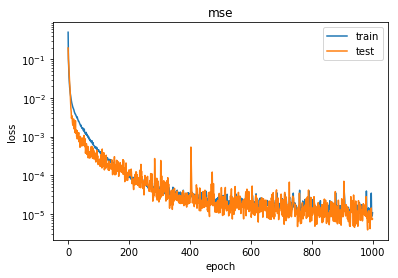

In [10]:
fig = plt.figure()
plt.semilogy(history.history['loss'])
if vsplit:
    plt.semilogy(history.history['val_loss'])
plt.title('mse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# model prediction test

In [11]:
model.load_weights("./tmp/weights.best.cntk.hdf5")

predict = model.predict(x_train)
df_y_prdt = pd.DataFrame(data=predict, columns=out_item)

error = (predict - y_train) / y_train
df_error = abs(pd.DataFrame(data=error, columns=out_item))

y_prdt_inv = []
for itm in out_item:
    print(itm)
    out = label_norm_scalers[itm].inverse_transform(0.5 * (df_y_prdt[itm].values.reshape(-1, 1) + 1))
    out = label_std_scalers[itm].inverse_transform(out)
    y_prdt_inv.append(out)
y_prdt_inv = np.concatenate(y_prdt_inv, axis=1)
y_prdt_inv=(y_prdt_inv>0)*y_prdt_inv
df_y_prdt_inv = pd.DataFrame(data=y_prdt_inv, columns=out_item)

error_inv = (y_prdt_inv - train_new) / (train_new + 1e-10)
df_error_inv = abs(pd.DataFrame(data=error_inv, columns=out_item))

H2
H
O2
OH
O
H2O
HO2
H2O2
N2


# accuracy curves

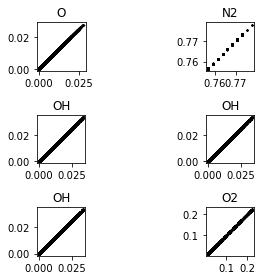

In [25]:
import random

f, axarr = plt.subplots(3, 2)
for i in range(3):
    sp = random.choice(out_item)
    axarr[i, 0].plot(train_new[sp], df_y_prdt_inv[sp], 'kd', ms=1)
    axarr[i, 0].set_title(sp)
    axarr[i, 0].set_aspect('equal', 'box')

    sp = random.choice(out_item)
    axarr[i, 1].plot(train_new[sp], df_y_prdt_inv[sp], 'kd', ms=1)
    axarr[i, 1].set_title(sp)
    axarr[i, 1].set_aspect('equal', 'box')
    f.tight_layout()
plt.show()

In [31]:
from sklearn.metrics import r2_score

def acc_plt(sp):
    plt.figure()
    plt.plot(train_new[sp], df_y_prdt_inv[sp], 'kd', ms=1)
    plt.axis('tight')
    plt.axis('equal')
    TestR2Value = r2_score(train_new[sp].values.reshape(-1), df_y_prdt_inv[sp].values.reshape(-1))

    plt.title(sp+'(R2 = '+str(TestR2Value)+')')
    plt.show()

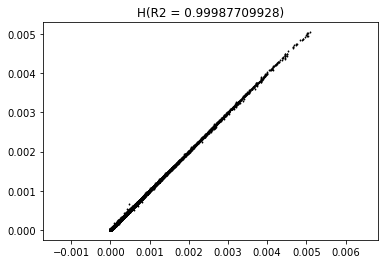

In [32]:
acc_plt('H')

# reference

![haha](https://raw.githubusercontent.com/uqyge/cantera/master/img/imperial.png)